In [1]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import seaborn as sns
import sys
import torch.nn.functional as F
# Req for package
sys.path.append("../")
from SkinLearning.Utils.Dataset import getDataset, getSplit
from SkinLearning.Utils.Plotting import plotParameterBars
from SkinLearning.Utils.NN import train, test, DEVICE

torch.backends.cudnn.benchmark = True

In [409]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler()

a = [
    [6, 2, 3, 4],
    [2, 2, 2, 2],
    [4, 2, 6, 2]
]

s.fit_transform(a)

array([[1.  , 0.  , 0.25, 1.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 1.  , 0.  ]])

In [2]:
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        self.fc1 = nn.Linear(131072, 1024)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024 , 512)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        x = self.d1(torch.relu(self.fc1(x)))
        
        x = self.d2(torch.relu(self.fc2(x)))
        
        x = self.d3(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        
        x = x.view(batch_size, 6)
        return x

In [95]:
# Up samples to 256 from 128
class BestUp(nn.Module):
    def __init__(self):
        super(BestUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        self.d3 = nn.Dropout(0.2)
        
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc1 = nn.Linear(131072, 1024)
        self.d4 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.d5 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d6 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d1(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d2(self.conv2(x)))))
        x = self.pool3(torch.relu(self.d3(self.bn3(self.conv3(x)))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d4(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d5(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d6(x)
        
        
        x = self.fc4(x)
        return x

In [107]:
# Up samples to 256 from 128
class BestUp2(nn.Module):
    def __init__(self):
        super(BestUp2, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        
        self.rnn = nn.RNN(30, 64, batch_first=True)
        
        self.fc1 = nn.Linear(32768, 1024)
        self.d4 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.d5 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d6 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d1(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d2(self.conv2(x)))))
        
        h0 = torch.zeros(1, batch_size, 128).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d4(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d5(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d6(x)
        
        
        x = self.fc4(x)
        return x

In [103]:
# Remove one FC LAyer
class RNNMinus(nn.Module):
    def __init__(self):
        super(RNNMinus, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        self.fc1 = nn.Linear(131072, 1024)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024 , 512)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        x = self.d1(torch.relu(self.fc1(x)))
        
        x = self.d2(torch.relu(self.fc2(x)))
        
        x = self.fc3(x)
        
        x = x.view(batch_size, 6)
        return x

In [6]:
# Remove one FC LAyer
class RNNPlus(nn.Module):
    def __init__(self):
        super(RNNPlus, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        self.fc1 = nn.Linear(131072, 1024)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024 , 512)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 64)
        self.d4 = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        x = self.d1(torch.relu(self.fc1(x)))
        
        x = self.d2(torch.relu(self.fc2(x)))
        
        x = self.d3(torch.relu(self.fc3(x)))
        x = self.d4(torch.relu(self.fc4(x)))
        x = self.fc5(x)
        
        x = x.view(batch_size, 6)
        return x

In [4]:
dataset, scaler = getDataset()

100%|██████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:32<00:00, 68.39it/s]


In [5]:
train_loader, test_loader = getSplit(dataset)

In [6]:
rnn = RNN()

In [7]:
rnn_losses, rnn_val_losses, = train(train_loader, rnn, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 5/5: 100%|█████████████████████████████████████| 56/56 [00:02<00:00, 20.43batch/s, lastLoss=0.182, valLoss=0.153]


Average train loss: 0.20268743586327345
Average validation loss: 0.1771897099415461


In [25]:
bestUp = BestUp()

In [26]:
bestUp_losses, bestUp_val_losses, = train(train_loader, bestUp, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 136/400: 100%|██████████████████████████████████| 56/56 [00:07<00:00,  7.12batch/s, lastLoss=0.106, valLoss=0.15]


Epoch 272/400: 100%|█████████████████████████████████| 56/56 [00:07<00:00,  7.12batch/s, lastLoss=0.0955, valLoss=0.13]


Epoch 400/400: 100%|████████████████████████████████| 56/56 [00:07<00:00,  7.11batch/s, lastLoss=0.0894, valLoss=0.129]


Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm
Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10
Average parameter loss: [0.07759943 0.15793171 0.0856686  0.15078043 0.0633011  0.09670253]
Average overall loss: 5.877825721450345e-05


In [108]:
bestUp2 = BestUp2()

In [111]:
import gc
torch.cuda.empty_cache()
gc.collect()

1088

In [110]:
bestUp2_losses, bestUp2_val_losses, = train(train_loader, bestUp2, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 58/400:  52%|█████████████████▌                | 29/56 [00:02<00:02, 12.86batch/s, lastLoss=0.117, valLoss=0.144]


KeyboardInterrupt: 

In [27]:
rnnMinus = RNNMinus()

In [28]:
rnnMinus_losses, rnnMinus_val_losses, = train(train_loader, rnnMinus, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 136/400: 100%|███████████████████████████████| 56/56 [00:07<00:00,  7.05batch/s, lastLoss=0.0758, valLoss=0.0593]


Epoch 272/400: 100%|███████████████████████████████| 56/56 [00:07<00:00,  7.17batch/s, lastLoss=0.0606, valLoss=0.0509]


Epoch 400/400: 100%|███████████████████████████████| 56/56 [00:08<00:00,  6.44batch/s, lastLoss=0.0538, valLoss=0.0475]


Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm
Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10
Average parameter loss: [0.06600015 0.10212678 0.07352379 0.09585582 0.04451023 0.06442019]
Average overall loss: 4.1521296379219816e-05


In [29]:
rnnPlus = RNNPlus()

In [30]:
rnnPlus_losses, rnnPlus_val_losses, = train(train_loader, rnnPlus, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 136/400: 100%|████████████████████████████████| 56/56 [00:07<00:00,  7.07batch/s, lastLoss=0.114, valLoss=0.0904]


Epoch 272/400: 100%|████████████████████████████████| 56/56 [00:08<00:00,  6.83batch/s, lastLoss=0.0982, valLoss=0.076]


Epoch 400/400: 100%|████████████████████████████████| 56/56 [00:08<00:00,  6.88batch/s, lastLoss=0.0932, valLoss=0.065]


Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm
Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10
Average parameter loss: [0.0862911  0.15584857 0.09046844 0.15422376 0.08023519 0.11496847]
Average overall loss: 6.343336611150465e-05


In [43]:
sns.set_theme()

"""
    Plots train and test curves of given models
"""
def printCurves(names, train_loss, val_loss, epochs=400, name="train_test2"):
    if len(names)%2 == 0:
        rs = len(names)//2
        cs = len(names)//2
    else:
        rs, cs = len(names), 1
        
    fig, ax = plt.subplots(
        rs, cs, figsize=(35 if len(names) != 1 else 10, len(names)*6), sharex=True, sharey=True, constrained_layout=True)
    x = range(0, epochs)
    fig.supxlabel("Epoch", fontsize=45)
    fig.supylabel("MAE", fontsize=45)

    #ax[0][1].set_xlabel("Training Loss")
    ##ax[1][1].set_xlabel("Validation Loss")
    
    tv_loss = list(zip(train_loss, val_loss))
    if cs == 1 and rs == 1:
        ax.set_title(names[0], fontsize=40)
        ax.xaxis.set_tick_params(labelsize=35)
        ax.yaxis.set_tick_params(labelsize=35)
        for j in range(2):
            ax.plot(x, tv_loss[0][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
    elif cs == 1:
        for i in range(len(names)):
            ax[i].set_title(names[i], fontsize=40)
            ax[i].xaxis.set_tick_params(labelsize=35)
            ax[i].yaxis.set_tick_params(labelsize=35)
            for j in range(2):
                ax[i].plot(x, tv_loss[i][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
    else:
        pos = 0
        for i in range(rs):
            for j in range(cs):
                ax[i][j].set_title(names[pos], fontsize=40)
                ax[i][j].xaxis.set_tick_params(labelsize=35)
                ax[i][j].yaxis.set_tick_params(labelsize=35)
                for k in range(2):
                    ax[i][j].plot(x, tv_loss[pos][k], c = "b" if k == 0 else "y", label = "Train loss" if k == 0 else "Validation loss")
    
                pos += 1
        
    #plt.xticks(fontsize=14, rotation=90)
    plt.legend(loc='best', prop={'size':30})
    plt.show()
    fig.savefig(f"../Results/{name}.svg", bbox_inches='tight')

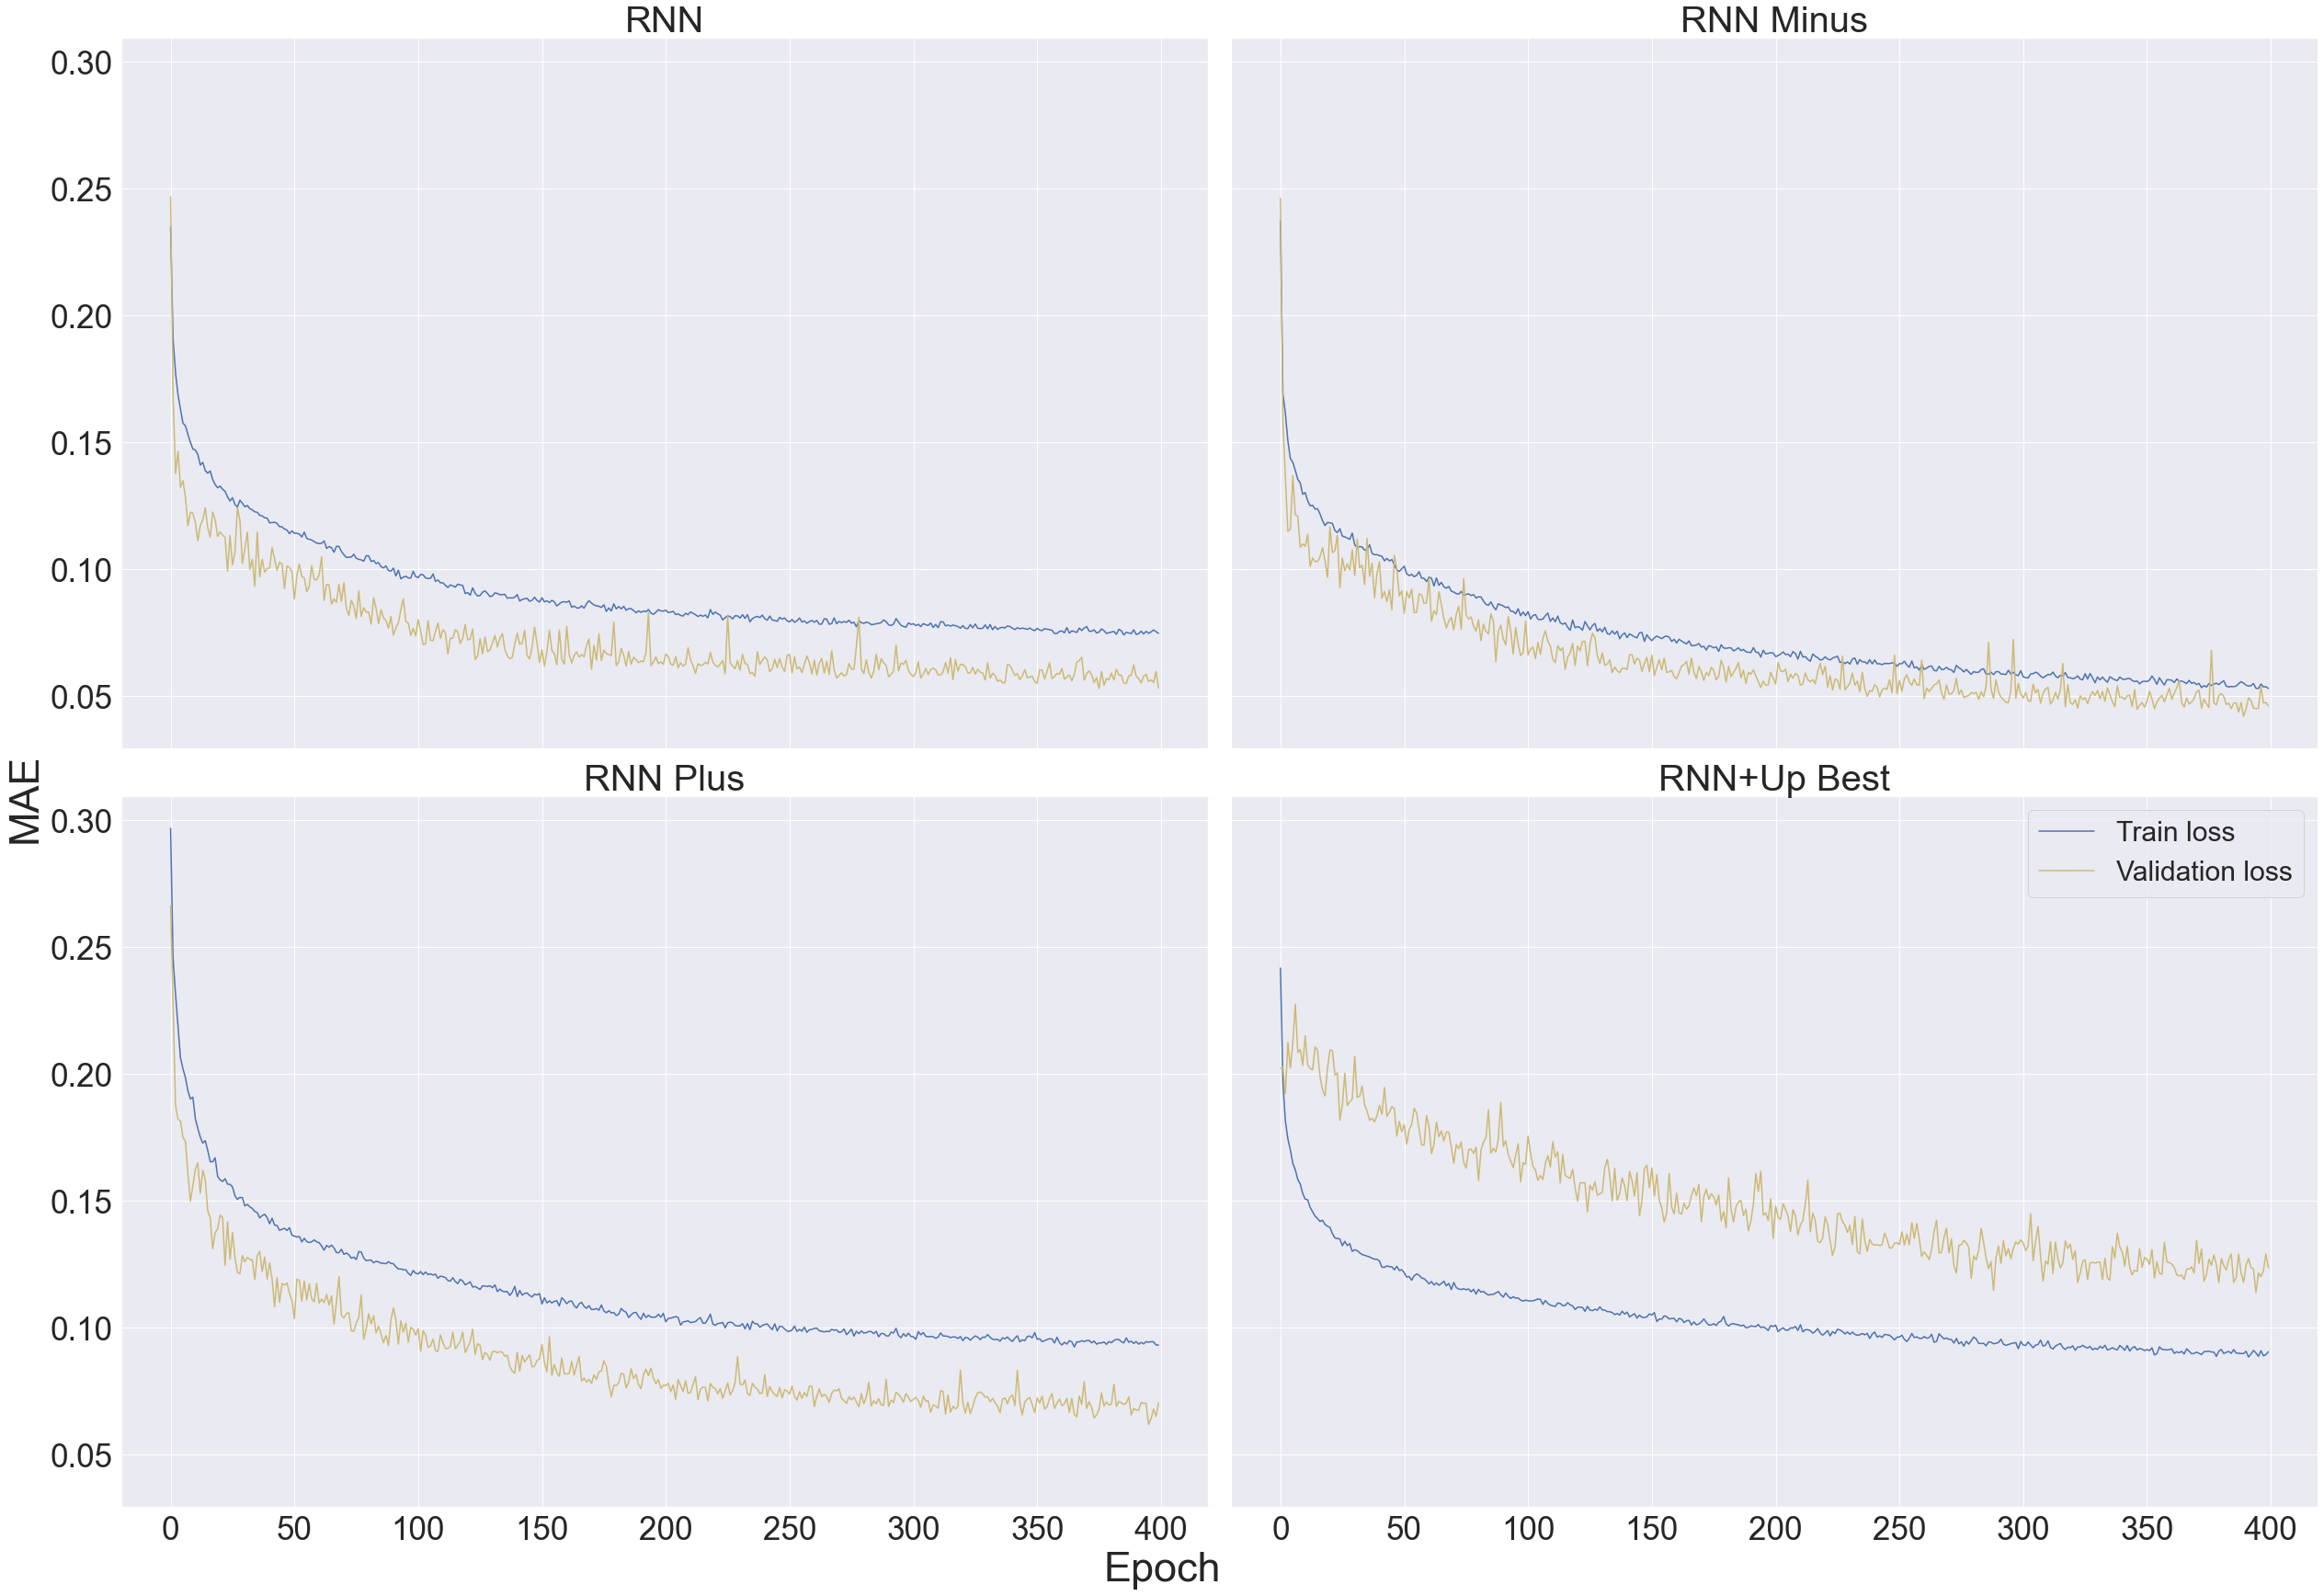

In [44]:
printCurves(
    ["RNN", "RNN Minus", "RNN Plus", "RNN+Up Best"],
    [rnn_losses, rnnMinus_losses, rnnPlus_losses, bestUp_losses],
    [rnn_val_losses, rnnMinus_val_losses, rnnPlus_val_losses, bestUp_val_losses])

In [11]:
def mape(y_true, y_pred):
    """Calculates the Mean Absolute Percentage Error (MAPE) between the true and predicted values."""
    absolute_error = torch.abs(y_true - y_pred)
    absolute_percentage_error = absolute_error / (torch.abs(y_true) + 1e-30)
    mape = 100.0 * torch.mean(absolute_percentage_error)
    return mape.item()

In [12]:
test(test_loader, rnn)

100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 99.67 batch/s]


(77.09398078918457,
 array([93.18033 , 61.769897, 99.71775 , 99.19269 , 47.064583, 61.638653],
       dtype=float32),
 0.1411849667628606)

In [291]:
ps

array([6957.86666667, 1226.13333333, 7218.2       , 2992.06666667,
       3856.2       ,  456.93333333])

In [399]:
"""
    Run evaluation and build a dataframe of parameter accuracies
    Accuracies are calculated as 100-MAPE
"""
def getParameterLoss(models, names, test_loader=test_loader):
    params = []
    overall = []
    
    # Run evaluation on all models
    for model in models:
        avg, ps, _ = test(test_loader, model)
        overall.append(avg)
        params.append(ps)
        
    all_vals = np.array(params)
    df = pd.DataFrame({
        "Architecture": names,
        "YM (Skin)": all_vals[:, 0],
        "YM (Adipose)": all_vals[:, 1],
        "PR (Skin)": all_vals[:, 2],
        "PR (Adipose)": all_vals[:, 3],
        "Perm (Skin)": all_vals[:, 4],
        "Perm (Adipose)": all_vals[:, 5],
        "Overall": overall
    })
    
    df = df.set_index("Architecture")
    df_p = df.style.set_caption(
        'Average percent correctness 100-MAPE').set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center')
        ]
    }])
    display(df_p)
    
    return df

In [400]:
df = getParameterLoss([rnn, rnnMinus, rnnPlus, bestUp, up],["RNN", "RNN Minus", "RNN Plus", "RNN+Up Best", "Up"])

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.76 batch/s]


,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
RNN,99.028778,89.304855,99.914879,99.782158,90.126488,99.634552,96.298618
RNN Minus,96.836090,96.204880,99.818230,99.943207,97.259109,98.661385,98.120483
RNN Plus,93.809166,86.286346,99.736801,99.890060,64.492165,99.475388,90.614987
RNN+Up Best,95.475487,86.854904,99.961113,99.830162,47.904045,81.956306,85.330337
Up,94.632263,60.971745,99.619987,98.810928,68.369614,83.922707,84.387874


In [ ]:
plotParameterBars(df)

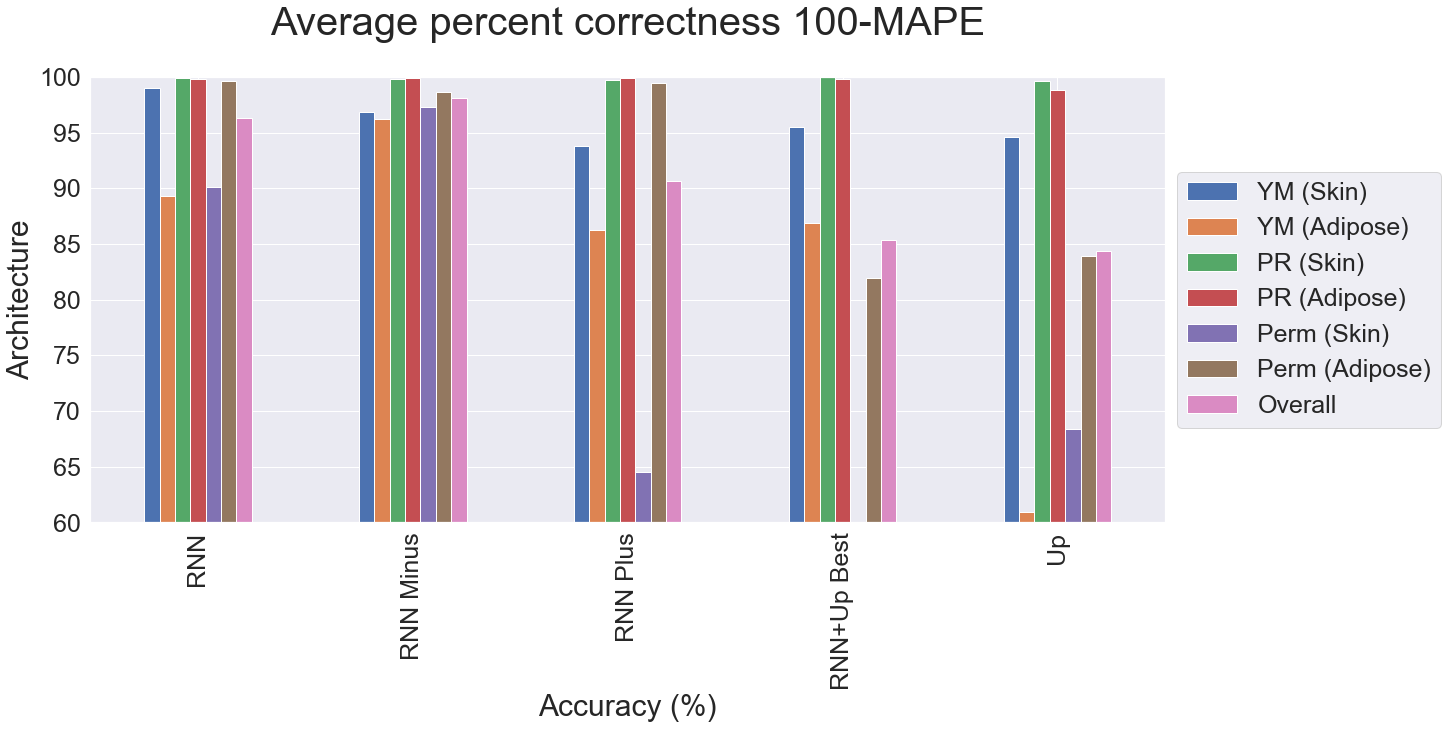

In [401]:
plotParameterBars(df)

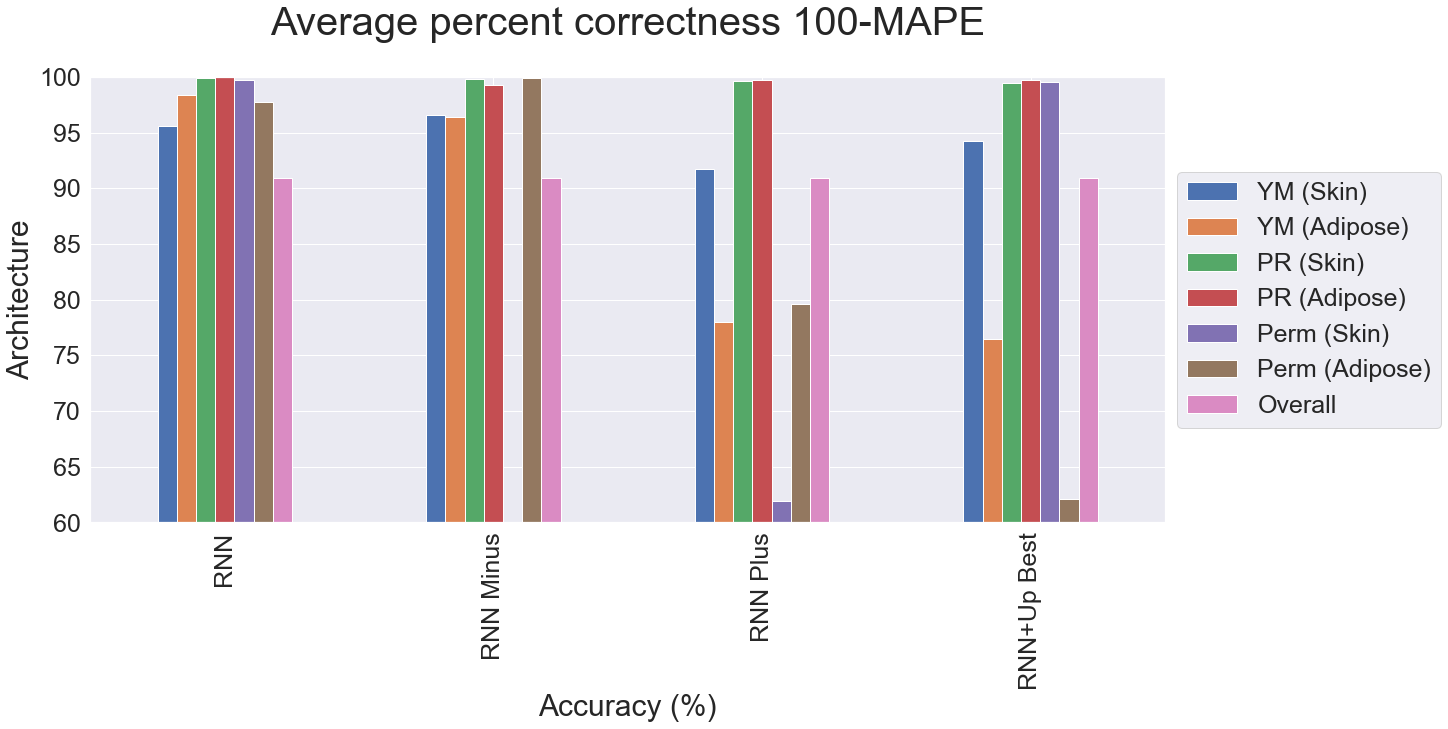

In [393]:
plotParameterBars(df)

In [394]:
# Up samples to 256 from 128
class DualUp(nn.Module):
    def __init__(self):
        super(DualUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1024)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        x = self.fc4(x)
        return x

In [395]:
up = DualUp()

In [396]:
upLoss, up_ploss, up_vloss = train(train_loader, up, val_loader=test_loader, LR=0.0001, epochs=400)

Using: cuda:0


Epoch 136/400: 100%|█████████████████████████████████| 56/56 [00:04<00:00, 13.30batch/s, lastLoss=0.122, valLoss=0.114]


Epoch 272/400: 100%|████████████████████████████████| 56/56 [00:04<00:00, 13.20batch/s, lastLoss=0.107, valLoss=0.0969]


Epoch 400/400: 100%|████████████████████████████████| 56/56 [00:04<00:00, 13.06batch/s, lastLoss=0.0987, valLoss=0.166]


Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm
Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10
Average parameter loss: [0.08719833 0.17417778 0.0906848  0.16766734 0.0826012  0.11828552]
Average overall loss: 6.702148373956241e-05
